In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import datetime
import math
import re
import time
import random
import os
import pickle
import concurrent.futures
import json

from pandas.tseries.offsets import *
from operator import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings 
warnings.filterwarnings('ignore')

In [2]:
seed = 42 #Setting seed.

df_train = pd.read_csv('../data/data/train.csv', 
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

df_submit = pd.read_csv('../data/data/test.csv', 
                        parse_dates=['Date'],
                        date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

df_store = pd.read_csv('../data/data/store.csv')

### Converting Sales to SalesLog

In this dataset we have to minimize Root Mean Squared Percentage Error(RMSPE). As I read the discussion on the Kaggle, I found that many machine learning algorithm doesn't support RMSPE as objective function. Thus to get a way around **Sales** is transformed using **log1p**.

In [4]:
df_train['SalesLog'] = np.log1p(df_train['Sales']) # = np.log(df_train['Sales'] + 1)

In [5]:
#Joining store data and train data.
df = pd.merge(df_train, df_store, how='left', on='Store')

In [ ]:
df.head()

## Creating Outlier Column based on mean absolute deviation.

In [7]:
def mad_based_outlier(points, thresh=3.5):
    '''
    This function will calculate mean absolute deviation and return true or 
    false based on points which have MAD greater than threshold provided.
    '''
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [8]:
#Creating new column 'Outlier' which tells whether a point is outlier or not.
for i in df['Store'].unique():
    df.loc[(df['Store'] == i) & (df['Open'] == 1), 'Outlier'] = \
        mad_based_outlier(df.loc[(df['Store'] == i) & (df['Open'] == 1)]['Sales'], 3.5)

## Feature Engineering.

### Date features.

In [9]:
# df['Date'] = pd.to_datetime(X['Date'], format='%Y%m%d')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.weekofyear
df['DayOfYear'] = df['Date'].dt.dayofyear

### Holidays this week, last week and next week.

In [10]:
dict_for_store_holidays = dict()

In [ ]:
for j in df['Store'].unique():

    a = df.loc[df['Store']==j]
    a.sort_values(['Date'], inplace=True)

    holidays_last_week, holidays_this_week, holidays_next_week = [], [], []
    this_week_dict= dict()

    for i in range(len(a)):

        present_week = a.iloc[i]['WeekOfYear']
        present_year = a.iloc[i]['Year']
        
        df_present = a.loc[(a['WeekOfYear']==present_week) & (a['Year']==present_year) & (a['Open']==0)]

        holidays = len(df_present)

        if (present_year,present_week) not in this_week_dict.keys():
            this_week_dict[(present_year,present_week)] = holidays
        else:
            continue
    
    dict_for_store_holidays[j] = this_week_dict

In [ ]:
for key in dict_for_store_holidays.keys():
  if type(key) is not str:
    try:
      dict_for_store_holidays[str(key)] = dict_for_store_holidays[key]
    except:
      try:
        dict_for_store_holidays[repr(key)] = dict_for_store_holidays[key]
      except:
        pass
    del dict_for_store_holidays[key]

In [ ]:
for key in dict_for_store_holidays.keys():
  if type(key)==np.int64:
    try:
      dict_for_store_holidays[str(key)] = dict_for_store_holidays[key]
    except:
      try:
        dict_for_store_holidays[repr(key)] = dict_for_store_holidays[key]
      except:
        pass
    del dict_for_store_holidays[key]

In [ ]:
import pickle

with open('../data/data/holidays_dict', 'wb') as f:
    pickle.dump(dict_for_store_holidays, f)

In [ ]:
for j in df['Store'].unique():

    a = df.loc[df['Store']==j]
    a.sort_values(['Date'], inplace=True)

    holidays_last_week, holidays_this_week, holidays_next_week = [], [], []
    this_week_dict= dict()

    #Calculate holidays for every week per store.
    for i in range(len(a)):

        present_week = a.iloc[i]['WeekOfYear']
        present_year = a.iloc[i]['Year']
        
        df_present = a.loc[(a['WeekOfYear']==present_week) & (a['Year']==present_year) & (a['Open']==0)]

        holidays = len(df_present)

        if (present_year,present_week) not in this_week_dict.keys():
            this_week_dict[(present_year,present_week)] = holidays
        else:
            continue

    #Adding holidays using the dict created above.
    for i in range(len(a)):

        present_week = a.iloc[i]['WeekOfYear']
        present_year = a.iloc[i]['Year']

        holidays_this_week.append(this_week_dict[(present_year,present_week)])

        #Boundary case for past week.
        if present_week != 1:
            past_week = present_week - 1
            past_year = present_year
        else:
            past_week = 52
            past_year = present_year - 1
        try:
            holidays_last_week.append(this_week_dict[(past_year,past_week)])
        except:
            holidays_last_week.append(np.nan)

        #Boundary case for future week.
        if present_week != 52:
            future_week = present_week + 1
            future_year = present_year
        else:
            future_week = 1
            future_year = present_year + 1
        try:
            holidays_next_week.append(this_week_dict[(future_year,future_week)])
        except:
            holidays_next_week.append(np.nan)
    
    a['holidays_this_week'] = holidays_this_week
    a['holidays_last_week'] = holidays_last_week
    a['holidays_next_week'] = holidays_next_week

    if j == 1:
        k = a
    else:
        k = pd.concat([k,a])

In [ ]:
k.sort_values('Date', inplace=True)

In [ ]:
k.to_csv('../data/data/df_store_holidays_counter', index=False)

### State Holiday counter.


In [ ]:
df = pd.read_csv('../data/data/df_store_holidays_counter',
                 parse_dates=['Date'],
                 date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

In [ ]:
def state_counter(a):
    '''
    This function adds 6 new features to the dataset. These features counts the 
    number of days before or after a promo and school holiday.
    '''
    
    a['Date'] = pd.to_datetime(a['Date'])
    a = a.sort_values('Date')

    list_to_store_state_holiday_before_days = []
    list_to_store_state_holiday_after_days = []

    for j in range(len(a)): 

        state_before_days = 0
        state_after_days = 0

        #Loop to count days before a State Hoiday.
        for l in range(j, len(a)):
            if a.iloc[l]['StateHoliday'] == '0':
                state_before_days += 1
            else:
                break
        
        list_to_store_state_holiday_before_days.append(state_before_days)

        #Loop to count days after a State Hoiday.
        for m in range(j, 0, -1):
            if a.iloc[m]['StateHoliday'] == '0':
                state_after_days += 1
            else:
                break
        
        list_to_store_state_holiday_after_days.append(state_after_days)

    a['State_holiday_before_days'] = list_to_store_state_holiday_before_days
    a['State_holiday_after_days'] = list_to_store_state_holiday_after_days

    return a

In [ ]:
list_of_individual_store_dataframes = []

for i in df['Store'].unique():
    m = df.loc[df['Store']==i]
    list_of_individual_store_dataframes.append(m)

start = time.time()

with concurrent.futures.ProcessPoolExecutor() as executor:

    empty_list = []

    for i in executor.map(state_counter, list_of_individual_store_dataframes):
        empty_list.append(i)

print(f'Time taken is equal to {(time.time() - start)/60} minutes.')

Time taken is equal to 70.48361271619797 minutes.


In [ ]:
n = pd.concat(empty_list)
n.sort_values(by=['Year','Day'], inplace=True)
n.to_csv('../data/data/df_state_counter_data_no_zeros', index=False)

### Days counter before and after an event.

In [ ]:
df = pd.read_csv('../data/data/df_state_counter_data_no_zeros',
                 parse_dates=['Date'],
                 date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

In [ ]:
df['StateHoliday'].replace(0, '0', inplace=True)

Promo and School holiday counter.


In [ ]:
def ps_counter(a):
    '''
    This function adds 6 new features to the dataset. These features counts the 
    number of days before or after a promo and school holiday.
    '''
    
    a['Date'] = pd.to_datetime(a['Date'])
    a = a.sort_values('Date')

    list_to_store_promo_before_days = []
    list_to_store_promo_after_days = []

    list_to_store_school_holiday_before_days = []
    list_to_store_school_holiday_after_days = []

    for j in range(len(a)): 

        before_days = 0
        after_days = 0
        
        school_before_days = 0
        school_after_days = 0

        #Loop to count days before a Promo.
        for k in range(j, len(a)):
            if a.iloc[k]['Promo'] != 1:
                before_days += 1
            else:
                break
        
        list_to_store_promo_before_days.append(before_days)

        #Loop to count days after a Promo.
        for v in range(j, 0, -1):
            if a.iloc[v]['Promo'] != 1:
                after_days += 1
            else:
                break
        
        list_to_store_promo_after_days.append(after_days)

        #Loop to count days before a School Hoiday.
        for l in range(j, len(a)):
            if a.iloc[l]['SchoolHoliday'] != 1:
                school_before_days += 1
            else:
                break
        
        list_to_store_school_holiday_before_days.append(school_before_days)

        #Loop to count days after a School Hoiday.
        for m in range(j, 0, -1):
            if a.iloc[m]['SchoolHoliday'] != 1:
                school_after_days += 1
            else:
                break
        
        list_to_store_school_holiday_after_days.append(school_after_days)

    a['Promo_before_days'] = list_to_store_promo_before_days
    a['Promo_after_days'] = list_to_store_promo_after_days

    a['School_holiday_before_days'] = list_to_store_school_holiday_before_days
    a['School_holiday_after_days'] = list_to_store_school_holiday_after_days

    return a

In [ ]:
list_of_individual_store_dataframes = []

for i in range(1,1116):
    m = df.loc[df['Store']==i]
    list_of_individual_store_dataframes.append(m)

start = time.time()

with concurrent.futures.ProcessPoolExecutor() as executor:

    empty_list = []

    for i in executor.map(ps_counter, list_of_individual_store_dataframes):
        empty_list.append(i)

print(f'Time taken is equal to {(time.time() - start)/60} minutes.') 

Time taken is equal to 180.19012438853582 minutes.


In [ ]:
n = pd.concat(empty_list)
n.sort_values(by=['Year','Day'], inplace=True)
n.to_csv('../data/data/df_counter_data_no_zeros', index=False)

### Dummy variable for close.

In [ ]:
df = pd.read_csv('../data/data/df_counter_data_no_zeros',
                 parse_dates=['Date'],
                 date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

In [ ]:
for i in range(1,1116):

    a = df.loc[df['Store'] == i]
    a['Date'] = pd.to_datetime(a['Date'])
    a = a.sort_values('Date')
    l = []

    for j in range(len(a)):
        if j != len(a)-1:
            if a.iloc[j+1]['Open']==0 or a.iloc[j-1]['Open']==0:
                l.append(1)
            else:
                l.append(-1)
        else:
            if a.iloc[j-1]['Open']==0:
                l.append(1)
            else:
                l.append(-1)
    a['Dummy_close'] = l

    if i==1:
        q = a
    else:
        q = pd.concat([q,a])

In [ ]:
q.sort_values(['Year','Day'], inplace=True)
q.to_csv('../data/data/df_dummy_no_zeros', index=False)

### Removing stores with zero sales.

In [ ]:
df = pd.read_csv('../data/data/df_dummy_no_zeros',
                 parse_dates=['Date'],
                 date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

In [ ]:
df = df.loc[~(df['Sales'] == 0)]

### Sales_per_day, Customers_per_day and Sales_per_customers_per_day.

In [ ]:
# Get total sales, customers and open days per store
store_data_sales = df.groupby([df['Store']])['Sales'].sum()
store_data_customers = df.groupby([df['Store']])['Customers'].sum()
store_data_open = df.groupby([df['Store']])['Open'].count()

In [ ]:
# Calculate sales per day, customers per day and sales per customers per day
store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

In [ ]:
#Saving the above values in a dictionary so that they can be mapped to the dataframe.
sales_per_day_dict = dict(store_data_sales_per_day)
customers_per_day_dict = dict(store_data_customers_per_day)
sales_per_customers_per_day_dict = dict(store_data_sales_per_customer_per_day)

In [ ]:
#Storing the abov dictionary so that they can be used during deploying the model.
import json

with open('../data/data/sales_per_day_dict_no_zeros', 'w') as f:
    json.dump(sales_per_day_dict, f)

with open('../data/data/customers_per_day_dict_no_zeros', 'w') as f:
    json.dump(customers_per_day_dict, f)

with open('../data/data/sales_per_customers_per_day_dict_no_zeros', 'w') as f:
    json.dump(sales_per_customers_per_day_dict, f)

In [ ]:
df['SalesPerDay'] = df['Store'].map(sales_per_day_dict)
df['Customers_per_day'] = df['Store'].map(customers_per_day_dict)
df['Sales_Per_Customers_Per_Day'] = df['Store'].map(sales_per_customers_per_day_dict)

del df['Customers']

In [ ]:
df.sort_values('Date', inplace=True)

#Removing all the outliers.
df = df.loc[df['Outlier']==False].drop('Outlier', axis=1)

###Competition Open and Promo Open.

In [ ]:
#Converting competition open to months.
df['CompetitionOpen '] = 12 * (df['Year'] - df['CompetitionOpenSinceYear']) + (df['Month'] - df['CompetitionOpenSinceMonth'])

#COnverting promo open to months.
df['PromoOpen'] = 12 * (df['Year'] - df['Promo2SinceYear']) + (df['WeekOfYear'] - df['Promo2SinceWeek']) / 4.0

###Feature generation using Promointerval.

In [ ]:
#Splitting PromoInterval into parts. For ex: (Jan,March,May) --> (Jan), (March), (May).
s = df['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
df = df.join(s)

In [ ]:
#Converting Promointerval columns to numerical.
month_to_num_dict = {
                    'Jan' : 1,
                    'Feb' : 2,
                    'Mar' : 3,
                    'Apr' : 4,
                    'May' : 5,
                    'Jun' : 6,
                    'Jul' : 7,
                    'Aug' : 8,
                    'Sept' : 9, 
                    'Oct' : 10,
                    'Nov' : 11,
                    'Dec' : 12,
                    'nan' : np.NaN
                    }


df['PromoInterval0'] = df['PromoInterval0'].map(month_to_num_dict)
df['PromoInterval1'] = df['PromoInterval1'].map(month_to_num_dict)
df['PromoInterval2'] = df['PromoInterval2'].map(month_to_num_dict)
df['PromoInterval3'] = df['PromoInterval3'].map(month_to_num_dict)

#Removing PromoInterval feature as no further use now.
del df['PromoInterval']

###Variation and acceleration of sales.

In [ ]:
imp = IterativeImputer(random_state=21)

In [ ]:
dict_to_store_variation_per_store = dict()
dict_to_store_acceleration_per_store = dict()
dict_to_store_weekly_rolling_mean_per_store = dict()
dict_to_store_monthly_rolling_mean_per_store = dict()

In [ ]:
for i in range(1,1116):

    a = df.loc[df['Store']==i]

    a['Variation'] = a['Sales'] - a['Sales'].shift()
    a['Acceleration'] = a['Sales'].shift() - a['Sales'].shift(2)
    a['Weekly_rolling_mean'] = a['Sales'].rolling(7).mean()
    a['Monthly_rolling_mean'] = a['Sales'].rolling(30).mean()

    imp.fit(a[['Variation','Acceleration','Weekly_rolling_mean','Monthly_rolling_mean']])
    imp.transform(a[['Variation','Acceleration','Weekly_rolling_mean','Monthly_rolling_mean']])

    #Storing last values of all four columns so that they can be used for test dataset.
    dict_to_store_variation_per_store[i] = a['Variation'].median() 
    dict_to_store_acceleration_per_store[i] = a['Acceleration'].median()
    dict_to_store_weekly_rolling_mean_per_store[i] = a['Weekly_rolling_mean'].median()
    dict_to_store_monthly_rolling_mean_per_store[i] = a['Monthly_rolling_mean'].median()

    if i==1:
        b = a
    else:
        b = pd.concat([a,b])

In [ ]:
#Storing the abov dictionary so that they can be used during deploying the model.
import json

with open('../data/data/vairation_dict_no_zeros', 'w') as f:
    json.dump(dict_to_store_variation_per_store, f)

with open('../data/data/acceleration_dict_no_zeros', 'w') as f:
    json.dump(dict_to_store_acceleration_per_store, f)

with open('../data/data/weekly_rolling_dict_no_zeros', 'w') as f:
    json.dump(dict_to_store_weekly_rolling_mean_per_store, f)

with open('../data/data/monthly_rolling_dict_no_zeros', 'w') as f:
    json.dump(dict_to_store_monthly_rolling_mean_per_store, f)

In [ ]:
b.sort_values(by=['Year','Day'], inplace=True)
b.to_csv('../data/data/df_variation_no_zeros', index=False)

###Average sales over past quarter and 6 months.

Adding past quarter same date mean and median.


In [ ]:
start = time.time()

b = pd.read_csv('../data/data/df_variation_no_zeros')

imp = IterativeImputer(random_state=21)

for j in range(1,1116):
    
    a = b.loc[b['Store']==j]
    l = [] #List to store median values.

    for i in range(len(a)):
        try:

            day = a.iloc[i]['Day']
            month = a.iloc[i]['Month']
            year = a.iloc[i]['Year']

            if month > 3:

                c = a.loc[()(a['Day']==day) & (a['Month'] == (month-1)) & (a['Year']==year)]['Sales']
                d = a.loc[(a['Day']==day) & (a['Month'] == (month-2)) & (a['Year']==year)]['Sales']
                e = a.loc[(a['Day']==day) & (a['Month'] == (month-3)) & (a['Year']==year)]['Sales']
                l.append(np.median([c.item(),d.item(),e.item()]))

            elif month ==3 :

                c = a.loc[(a['Day']==day) & (a['Month'] == (month-1)) & (a['Year']==year)]['Sales']
                d = a.loc[(a['Day']==day) & (a['Month'] == (month-2)) & (a['Year']==year)]['Sales']
                e = a.loc[(a['Day']==day) & (a['Month'] == (12)) & (a['Year']==(year-1))]['Sales']
                l.append(np.median([c.item(),d.item(),e.item()]))

            elif month ==2:

                c = a.loc[(a['Day']==day) & (a['Month'] == (month-1)) & (a['Year']==year)]['Sales']
                d = a.loc[(a['Day']==day) & (a['Month'] == (12)) & (a['Year']==(year-1))]['Sales']
                e = a.loc[(a['Day']==day) & (a['Month'] == (11)) & (a['Year']==(year-1))]['Sales']
                l.append(np.median([c.item(),d.item(),e.item()]))

            else:

                c = a.loc[(a['Day']==day) & (a['Month'] == (12)) & (a['Year']==(year-1))]['Sales']
                d = a.loc[(a['Day']==day) & (a['Month'] == (11)) & (a['Year']==(year-1))]['Sales']
                e = a.loc[(a['Day']==day) & (a['Month'] == (10)) & (a['Year']==(year-1))]['Sales']
                l.append(np.median([c.item(),d.item(),e.item()]))

        except:
            
            l.append(np.NaN)
        
    a['Previous_quarter_median'] = l

    imp.fit(a[['Previous_quarter_median']])
    imp.transform(a[['Previous_quarter_median']])

    if j==1:
        k = a
    else:
        k = pd.concat([k,a])

print(f'Time taken is {(time.time() - start)/60} minutes.')

Time taken is 29.81618643204371 minutes.


Adding past half year mean and median.

In [ ]:
list_of_individual_store_dataframes = []
for i in range(1,1116):
    j = k.loc[k['Store']==i]
    list_of_individual_store_dataframes.append(j)

In [ ]:
def half_year(z): #Here z is a dataframe of an individual store.

    b = []
    j = []
    for i in range(len(z)):
        try:
            day = z.iloc[i]['Day']
            month = z.iloc[i]['Month']
            year = z.iloc[i]['Year']
            if month > 6:
                c = z.loc[(z['Day']==day) & (z['Month'] == (month-1)) & (z['Year']==year)]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (month-2)) & (z['Year']==year)]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (month-3)) & (z['Year']==year)]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (month-4)) & (z['Year']==year)]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == (month-5)) & (z['Year']==year)]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (month-6)) & (z['Year']==year)]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
            elif month ==6 :
                c = z.loc[(z['Day']==day) & (z['Month'] == (month-1)) & (z['Year']==year)]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (month-2)) & (z['Year']==year)]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (month-3)) & (z['Year']==(year-1))]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (month-4)) & (z['Year']==year)]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == (month-5)) & (z['Year']==year)]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (12)) & (z['Year']==(year-1))]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
            elif month ==5 :
                c = z.loc[(z['Day']==day) & (z['Month'] == (month-1)) & (z['Year']==year)]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (month-2)) & (z['Year']==year)]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (month-3)) & (z['Year']==(year-1))]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (month-4)) & (z['Year']==year)]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == (month-5)) & (z['Year']==year)]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (month-6)) & (z['Year']==year)]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
            elif month ==4 :
                c = z.loc[(z['Day']==day) & (z['Month'] == (month-1)) & (z['Year']==year)]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (month-2)) & (z['Year']==year)]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (month-3)) & (z['Year']==(year-1))]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (12)) & (z['Year']==(year-1))]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == (11)) & (z['Year']==(year-1))]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (10)) & (z['Year']==(year-1))]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
            elif month ==3 :
                c = z.loc[(z['Day']==day) & (z['Month'] == (month-1)) & (z['Year']==year)]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (month-2)) & (z['Year']==year)]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (12)) & (z['Year']==(year-1))]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (11)) & (z['Year']==(year-1))]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == (10)) & (z['Year']==(year-1))]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (9)) & (z['Year']==(year-1))]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
            elif month ==2:
                c = z.loc[(z['Day']==day) & (z['Month'] == (month-1)) & (z['Year']==year)]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (12)) & (z['Year']==(year-1))]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (11)) & (z['Year']==(year-1))]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (10)) & (z['Year']==(year-1))]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == 9) & (z['Year']==(year-1))]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (8)) & (z['Year']==(year-1))]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
            else:
                c = z.loc[(z['Day']==day) & (z['Month'] == (12)) & (z['Year']==(year-1))]['Sales']
                d = z.loc[(z['Day']==day) & (z['Month'] == (11)) & (z['Year']==(year-1))]['Sales']
                e = z.loc[(z['Day']==day) & (z['Month'] == (10)) & (z['Year']==(year-1))]['Sales']
                f = z.loc[(z['Day']==day) & (z['Month'] == (9)) & (z['Year']==(year-1))]['Sales']
                g = z.loc[(z['Day']==day) & (z['Month'] == (8)) & (z['Year']==(year-1))]['Sales']
                h = z.loc[(z['Day']==day) & (z['Month'] == (7)) & (z['Year']==(year-1))]['Sales']
                b.append(np.median([c.item(),d.item(),e.item(),f.item(),g.item(),h.item()]))
        except:
            b.append(np.NaN)
            

    z['Previous_half_year_median'] = b
    z['Previous_half_year_median'] = z['Previous_half_year_median'].fillna(np.median(z['Previous_half_year_median']))

    return z

In [ ]:
start = time.time()

with concurrent.futures.ProcessPoolExecutor() as executor:

    empty_list = []

    for i in executor.map(half_year, list_of_individual_store_dataframes):
        empty_list.append(i)

print(f'Time taken is equal to {(time.time() - start)/60} minutes.') 

Time taken is equal to 88.59476081132888 minutes.


In [ ]:
l = pd.concat(empty_list)
l.sort_values(by=['Year','Day'], inplace=True)
l.to_csv('../data/data/df_average_sales_over_past_data_no_zeros', index=False)

In [ ]:
df_something = pd.read_csv('../data/data/df_average_sales_over_past_data_no_zeros')

In [ ]:
previous_quarter_dict_no_log = dict()
previous_half_year_dict_no_log = dict()

for i in range(1, 1116):

    a = df_something.loc[df_something['Store']==i]['Previous_quarter_median']
    b = df_something.loc[df_something['Store']==i]['Previous_half_year_median']

    mean_quarter = np.mean(a)
    mean_half_year = np.mean(b)

    previous_quarter_dict_no_log[i] = mean_quarter
    previous_half_year_dict_no_log[i] = mean_half_year

In [ ]:
json.dump(previous_quarter_dict_no_log, open('../data/data/previous_quarter_dict_no_zeros','w'))
json.dump(previous_half_year_dict_no_log, open('../data/data/previous_half_year_dict_no_zeros','w'))

###Central Tendencies over Day_of_week, Promo and Holidays.

In [ ]:
df = pd.read_csv('../data/data/df_average_sales_over_past_data_no_zeros')
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
day_of_week_store_dict_no_log = dict()

for i in range(1,1116):

    a = df.loc[df['Store']==i]

    day_of_week_median = dict()

    for j in range(1,8):

        c = a.loc[a['DayOfWeek']==j]['Sales'].median()

        day_of_week_median[j] = c
    
    promo_median = a.loc[a['Promo']==1]['Sales'].median()

    holiday_median = a.loc[a['SchoolHoliday']==1]['Sales'].median()

    a['Median_over_day_of_week'] = a['DayOfWeek'].map(day_of_week_median)

    day_of_week_store_dict_no_log[i] = day_of_week_median

    a['Promo_median_sales'] = promo_median

    a['Holiday_median_sales'] = promo_median

    if i==1:
        k = a
    else:
        k = pd.concat([k,a])

In [ ]:
json.dump(day_of_week_store_dict_no_log, open('../data/data/day_of_week_store_dict_no_zeros','w'))

In [ ]:
k.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,SalesLog,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,State,Year,Month,Day,WeekOfYear,DayOfYear,holidays_this_week,holidays_last_week,holidays_next_week,State_holiday_before_days,State_holiday_after_days,Promo_before_days,Promo_after_days,School_holiday_before_days,School_holiday_after_days,Dummy_close,SalesPerDay,Customers_per_day,Sales_Per_Customers_Per_Day,CompetitionOpen,PromoOpen,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3,Variation,Acceleration,Weekly_rolling_mean,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Promo_median_sales,Holiday_median_sales
0,1,5,2013-02-01,5633,1,0,0,0,8.636575,c,a,1270.0,9.0,2008.0,0,NaN,NaN,HE,2013,2,1,5,32,1,1.0,1.0,0,0,3,7,52,21,-1,4759.096031,564.049936,8.437366,53.0,NaN,NaN,NaN,NaN,NaN,924.0,108.0,4843.857143,NaN,NaN,NaN,4649.0,5199.5,5199.5
1,1,5,2013-03-01,4611,1,0,0,0,8.436417,c,a,1270.0,9.0,2008.0,0,NaN,NaN,HE,2013,3,1,9,60,1,1.0,1.0,28,1,3,7,24,49,-1,4759.096031,564.049936,8.437366,54.0,NaN,NaN,NaN,NaN,NaN,-65.0,118.0,4559.142857,5085.666667,NaN,NaN,4649.0,5199.5,5199.5
2,1,6,2013-06-01,5693,1,0,0,0,8.647168,c,a,1270.0,9.0,2008.0,0,NaN,NaN,HE,2013,6,1,22,152,2,2.0,1.0,25,2,2,1,35,57,1,4759.096031,564.049936,8.437366,57.0,NaN,NaN,NaN,NaN,NaN,-2200.0,2109.0,5503.428571,5149.300000,NaN,NaN,4773.0,5199.5,5199.5
3,1,1,2013-07-01,5614,1,1,0,0,8.633197,c,a,1270.0,9.0,2008.0,0,NaN,NaN,HE,2013,7,1,27,182,1,1.0,1.0,0,0,0,0,5,87,1,4759.096031,564.049936,8.437366,58.0,NaN,NaN,NaN,NaN,NaN,-190.0,1397.0,4475.714286,4773.866667,NaN,NaN,5280.0,5199.5,5199.5
4,1,4,2013-08-01,4994,1,1,0,1,8.516193,c,a,1270.0,9.0,2008.0,0,NaN,NaN,HE,2013,8,1,31,213,1,1.0,1.0,23,8,0,0,0,0,-1,4759.096031,564.049936,8.437366,59.0,NaN,NaN,NaN,NaN,NaN,-578.0,-201.0,4814.857143,4774.566667,NaN,NaN,4380.0,5199.5,5199.5


In [ ]:
k.sort_values(by=['Year','Day'], inplace=True)
k.to_csv('../data/data/df_average_sales_over_promo_holiday_no_zeros', index=False)

###Checking seasonalities using Fourier transform features.

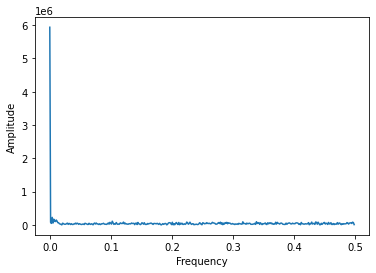

In [ ]:
#Store Type 'A'.
df_store_11_sales = df.loc[df['Store']==11]['Sales']

# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y = np.fft.fft(df_store_11_sales.values)
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(len(Y), 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

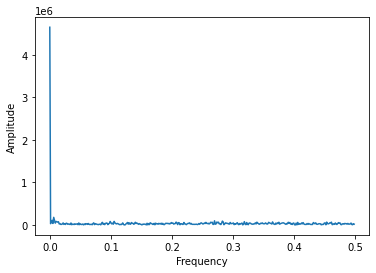

In [ ]:
#Store Type 'B'.
df_store_119_sales = df.loc[df['Store']==119]['Sales']

# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y = np.fft.fft(df_store_119_sales.values)
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(len(Y), 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

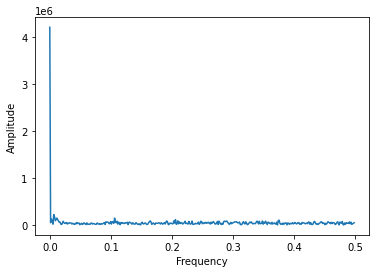

In [ ]:
#Store Type 'C'.
df_store_21_sales = df.loc[df['Store']==21]['Sales']

# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y = np.fft.fft(df_store_21_sales.values)
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(len(Y), 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

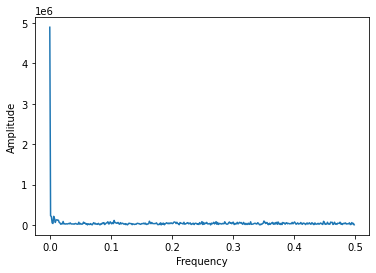

In [ ]:
#Store Type 'D'.
df_store_1115_sales = df.loc[df['Store']==1115]['Sales']

# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y = np.fft.fft(df_store_1115_sales.values)
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(len(Y), 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

Here in graphs we can see that at some places there are spikes at particular frequencies. These indicates the seasonality factor in the sales data. We can use these 3 frequencies and their respective amplitudes as features to represent a seasonal factor in the data.

In [ ]:
df = pd.read_csv('../data/data/df_average_sales_over_promo_holiday_no_zeros',
                 parse_dates=['Date'],
                 date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

In [ ]:
freq2_dict_no_log = dict()
freq3_dict_no_log = dict()

amp2_dict_no_log = dict()
amp3_dict_no_log = dict()

for i in range(1,1116):

    a = df.loc[df['Store']==i]
    a.sort_values(['Year','DayOfYear'], inplace=True)
    a_sales = a['Sales']

    Y = np.fft.fft(a_sales.values)
    Y = abs(Y)
    freq = np.fft.fftfreq(len(Y), 1)

    intercept_index = np.argmax(Y)
    Y = np.delete(Y, intercept_index)
    freq = np.delete(freq, intercept_index)

    amplitude_1_index = np.argmax(Y)
    amplitude_1 = Y[amplitude_1_index]
    Y = np.delete(Y, amplitude_1_index)
    freq_1 = freq[amplitude_1_index]
    freq = np.delete(freq, amplitude_1_index)

    amplitude_2_index = np.argmax(Y)
    amplitude_2 = Y[amplitude_2_index]
    Y = np.delete(Y, amplitude_2_index)
    freq_2 = freq[amplitude_2_index]
    freq = np.delete(freq, amplitude_2_index)

    amplitude_3_index = np.argmax(Y)
    amplitude_3 = Y[amplitude_3_index]
    Y = np.delete(Y, amplitude_3_index)
    freq_3 = freq[amplitude_3_index]
    freq = np.delete(freq, amplitude_3_index)

    a['Frequency_2'] = freq_2
    a['Frequency_3'] = freq_3

    a['Amplitude_2'] = amplitude_2
    a['Amplitude_3'] = amplitude_3

    
    freq2_dict_no_log[i] = freq_2
    freq3_dict_no_log[i] = freq_3

    amp2_dict_no_log[i] = amplitude_2
    amp3_dict_no_log[i] = amplitude_3


    if i == 1:
        k = a
    else:
        k = pd.concat([k,a])

In [ ]:
json.dump(freq2_dict_no_log, open('../data/data/freq2_dict_no_zeros','w'))
json.dump(freq3_dict_no_log, open('../data/data/freq3_dict_no_zeros','w'))

json.dump(amp2_dict_no_log, open('../data/data/amp2_dict_no_zeros','w'))
json.dump(amp3_dict_no_log, open('../data/data/amp3_dict_no_zeros','w'))

In [ ]:
k.sort_values(['Year','Day'], inplace=True)
k.to_csv('../data/data/df_fourier_no_zeros', index=False)

### Now adding some external data.

In [ ]:
df = pd.read_csv('../data/data/df_fourier_no_zeros', 
                 parse_dates=['Date'],
                 date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

In [ ]:
q = df['State'].unique()
q

array(['HE', 'TH', 'NW', 'BE', 'SN', 'SH', 'HB,NI', 'BY', 'BW', 'RP',
       'ST', 'HH'], dtype=object)

In [ ]:
for i in range(len(q)):

    a = df.loc[df['State']==q[i]]
    b = q[i]
    
    temp_df = pd.read_csv(f'../data/data/weather data/{b}.csv',
                   sep=';', parse_dates=['Date'],
                    date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))
    
    a = pd.merge(a, temp_df, how='left', on='Date')

    if i==0:
        k = a
    else:
        k = pd.concat([k,a])

In [ ]:
k.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837940 entries, 0 to 21950
Data columns (total 77 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Store                        837940 non-null  int64         
 1   DayOfWeek                    837940 non-null  int64         
 2   Date                         837940 non-null  datetime64[ns]
 3   Sales                        837940 non-null  int64         
 4   Open                         837940 non-null  int64         
 5   Promo                        837940 non-null  int64         
 6   StateHoliday                 837940 non-null  object        
 7   SchoolHoliday                837940 non-null  int64         
 8   SalesLog                     837940 non-null  float64       
 9   StoreType                    837940 non-null  object        
 10  Assortment                   837940 non-null  object        
 11  CompetitionDistance        

In [ ]:
k.drop('Max_Gust_SpeedKm_h', axis=1, inplace=True)
k.sort_values('Date', inplace=True)

In [ ]:
k.to_csv('../data/data/df_weather_no_zeros', index=False)

###Checking VIF.

In [ ]:
df = pd.read_csv('../data/data/df_weather_no_zeros')
df.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,SalesLog,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,State,Year,Month,Day,WeekOfYear,DayOfYear,holidays_this_week,holidays_last_week,holidays_next_week,State_holiday_before_days,State_holiday_after_days,Promo_before_days,Promo_after_days,School_holiday_before_days,School_holiday_after_days,Dummy_close,SalesPerDay,Customers_per_day,Sales_Per_Customers_Per_Day,CompetitionOpen,PromoOpen,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3,Variation,Acceleration,Weekly_rolling_mean,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Promo_median_sales,Holiday_median_sales,Frequency_2,Frequency_3,Amplitude_2,Amplitude_3,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,353,2,2013-01-01,3139,1,0,a,1,8.051978,b,b,900.0,NaN,NaN,1,14.0,2013.0,BW,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,5651.368817,1451.086022,3.894579,NaN,-3.25,2.0,5.0,8.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,5514.0,5805.5,5805.5,-0.001082,0.428571,362259.254095,272789.258298,8,3,-2,3,1,-3,93,80,51,1016,1011,1008,31.0,12.0,10.0,23,6,0.25,6.0,Fog-Rain,228
1,423,2,2013-01-01,9643,1,0,a,1,9.174091,b,a,1270.0,5.0,2014.0,0,NaN,NaN,BE,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,10828.403397,1886.130573,5.741068,-16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10195.0,11338.0,11338.0,-0.429487,0.286325,391277.072069,371198.715249,8,7,5,6,3,2,100,78,62,1009,1004,1003,31.0,14.0,10.0,26,18,0.76,6.0,Rain,216
2,948,2,2013-01-01,4491,1,0,a,1,8.410053,b,b,1430.0,NaN,NaN,0,NaN,NaN,BW,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,6944.243797,1714.269687,4.050847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6523.0,7069.0,7069.0,-0.001089,0.005447,388730.629793,316539.642562,8,3,-2,3,1,-3,93,80,51,1016,1011,1008,31.0,12.0,10.0,23,6,0.25,6.0,Fog-Rain,228
3,274,2,2013-01-01,3102,1,0,a,1,8.040125,b,b,3640.0,NaN,NaN,1,10.0,2013.0,HE,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,4070.828326,992.741416,4.100593,NaN,-2.25,1.0,4.0,7.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,3339.0,3678.5,3678.5,-0.006039,0.150966,114251.813759,84539.855512,8,6,3,6,3,1,93,80,59,1015,1008,1006,31.0,12.0,10.0,23,14,2.03,6.0,Rain,206
4,1097,2,2013-01-01,5961,1,0,a,1,8.693161,b,b,720.0,3.0,2002.0,0,NaN,NaN,RP,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,9744.599788,2420.921444,4.025161,130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9443.0,10222.0,10222.0,0.005353,-0.001071,305651.203930,276546.292577,8,6,4,7,3,1,92,75,59,1015,1010,1008,31.0,19.0,5.0,26,19,0.25,8.0,Rain,-1


In [ ]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median',add_indicator=True)

In [ ]:
type_assortment_dict = {'a':1,
                   'b':2,
                   'c':3,
                   'd':4,
                   '0':0,
                   0:0}

In [ ]:
df['StoreType'] = pd.to_numeric(df['StoreType'].map(type_assortment_dict))
df['Assortment'] = pd.to_numeric(df['Assortment'].map(type_assortment_dict))
df['State'] = pd.to_numeric(df['State'].astype('category').cat.codes)
df['StateHoliday'] = pd.to_numeric(df['StateHoliday'].map(type_assortment_dict))

In [ ]:
df['Promo2SinceWeek'] = pd.to_numeric(df['Promo2SinceWeek'].fillna(-1))
df['Promo2SinceYear'] = pd.to_numeric(df['Promo2SinceYear'].fillna(-1))
df['PromoOpen'] = pd.to_numeric(df['PromoOpen'].fillna(-1))
df['PromoInterval0'] = pd.to_numeric(df['PromoInterval0'].fillna(-1))
df['PromoInterval1'] = pd.to_numeric(df['PromoInterval1'].fillna(-1))
df['PromoInterval2'] = pd.to_numeric(df['PromoInterval2'].fillna(-1))
df['PromoInterval3'] = pd.to_numeric(df['PromoInterval3'].fillna(-1))

In [ ]:
df['Monthly_rolling_mean'] = pd.to_numeric(df['Monthly_rolling_mean'].fillna(df['Monthly_rolling_mean'].median()))
df['Previous_quarter_median'] = pd.to_numeric(df['Previous_quarter_median'].fillna(df['Previous_quarter_median'].median()))
df['Previous_half_year_median'] = pd.to_numeric(df['Previous_half_year_median'].fillna(df['Previous_half_year_median'].median()))

In [ ]:
df['CompetitionDistance'] = pd.to_numeric(df['CompetitionDistance'].fillna(df['CompetitionDistance'].median()))
df['CompetitionOpenSinceMonth'] = pd.to_numeric(df['CompetitionOpenSinceMonth'].fillna(df['CompetitionOpenSinceMonth'].median()))
df['CompetitionOpenSinceYear'] = pd.to_numeric(df['CompetitionOpenSinceYear'].fillna(df['CompetitionOpenSinceYear'].median()))

In [ ]:
df['CompetitionOpen '] = pd.to_numeric(df['CompetitionOpen '].fillna(-1))
df['Variation'] = pd.to_numeric(df['Variation'].fillna(df['Variation'].median()))
df['Acceleration'] = pd.to_numeric(df['Acceleration'].fillna(df['Acceleration'].median()))
df['Weekly_rolling_mean'] = pd.to_numeric(df['Weekly_rolling_mean'].fillna(df['Weekly_rolling_mean'].median()))

In [ ]:
X = df.drop(['Date','Sales','SalesLog'], axis=1)
X.head()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,State,Year,Month,Day,WeekOfYear,DayOfYear,holidays_this_week,holidays_last_week,holidays_next_week,State_holiday_before_days,State_holiday_after_days,Promo_before_days,Promo_after_days,School_holiday_before_days,School_holiday_after_days,Dummy_close,SalesPerDay,Customers_per_day,Sales_Per_Customers_Per_Day,CompetitionOpen,PromoOpen,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3,Variation,Acceleration,Weekly_rolling_mean,Monthly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Promo_median_sales,Holiday_median_sales,Frequency_2,Frequency_3,Amplitude_2,Amplitude_3,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,353,2,1,0,1,1,2,2,900.0,8.0,2010.0,1,14.0,2013.0,1,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,5651.368817,1451.086022,3.894579,-1.0,-3.25,2.0,5.0,8.0,11.0,-122.0,-123.0,6460.428571,6521.466667,6752.0,6424.0,5514.0,5805.5,5805.5,-0.001082,0.428571,362259.254095,272789.258298,8,3,-2,3,1,-3,93,80,51,1016,1011,1008,31.0,12.0,10.0,23,6,0.25,6.0,Fog-Rain,228
1,423,2,1,0,1,1,2,1,1270.0,5.0,2014.0,0,-1.0,-1.0,0,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,10828.403397,1886.130573,5.741068,-16.0,-1.00,-1.0,-1.0,-1.0,-1.0,-122.0,-123.0,6460.428571,6521.466667,6752.0,6424.0,10195.0,11338.0,11338.0,-0.429487,0.286325,391277.072069,371198.715249,8,7,5,6,3,2,100,78,62,1009,1004,1003,31.0,14.0,10.0,26,18,0.76,6.0,Rain,216
2,948,2,1,0,1,1,2,2,1430.0,8.0,2010.0,0,-1.0,-1.0,1,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,6944.243797,1714.269687,4.050847,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-122.0,-123.0,6460.428571,6521.466667,6752.0,6424.0,6523.0,7069.0,7069.0,-0.001089,0.005447,388730.629793,316539.642562,8,3,-2,3,1,-3,93,80,51,1016,1011,1008,31.0,12.0,10.0,23,6,0.25,6.0,Fog-Rain,228
3,274,2,1,0,1,1,2,2,3640.0,8.0,2010.0,1,10.0,2013.0,4,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,4070.828326,992.741416,4.100593,-1.0,-2.25,1.0,4.0,7.0,10.0,-122.0,-123.0,6460.428571,6521.466667,6752.0,6424.0,3339.0,3678.5,3678.5,-0.006039,0.150966,114251.813759,84539.855512,8,6,3,6,3,1,93,80,59,1015,1008,1006,31.0,12.0,10.0,23,14,2.03,6.0,Rain,206
4,1097,2,1,0,1,1,2,2,720.0,3.0,2002.0,0,-1.0,-1.0,7,2013,1,1,1,1,0,NaN,0.0,0,0,6,0,0,0,-1,9744.599788,2420.921444,4.025161,130.0,-1.00,-1.0,-1.0,-1.0,-1.0,-122.0,-123.0,6460.428571,6521.466667,6752.0,6424.0,9443.0,10222.0,10222.0,0.005353,-0.001071,305651.203930,276546.292577,8,6,4,7,3,1,92,75,59,1015,1010,1008,31.0,19.0,5.0,26,19,0.25,8.0,Rain,-1


In [ ]:
X.drop('CloudCover', axis=1, inplace=True)

In [ ]:
X.drop(['Max_VisibilityKm', 'Mean_VisibilityKm','Min_VisibilitykM'], axis=1, inplace=True)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#Adding constant as variance inflation factor needs a constant while calculating VIF.
X = add_constant(X)

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    variables = X.columns
    vif["variables"] = variables
    vif["VIF"] = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]

    return vif

In [ ]:
for i in X.columns:
    if X[i].isnull().any():
        print(i)

holidays_last_week
holidays_next_week


In [ ]:
X.dropna(inplace=True)

In [ ]:
X = X._get_numeric_data()

In [ ]:
pd.options.display.max_rows = 4000

In [ ]:
calc_vif(X)

,variables,VIF
0,Store,1.014414e+00
1,DayOfWeek,1.901302e+00
2,Open,1.633039e+07
3,Promo,2.037803e+01
4,StateHoliday,1.016532e+00
5,SchoolHoliday,2.502131e+00
6,StoreType,1.612439e+00
7,Assortment,1.254379e+00
8,CompetitionDistance,1.294305e+00
9,CompetitionOpenSinceMonth,1.102620e+00


Here we can see that there are many variables which have VIF equal to infinity. This shows the presence of multi-collinearity. Also there are significant number of features which have high VIF value. Now we will try removing them one by one and check which varaible decreases the overall VIF of the data.

In [ ]:
calc_vif(X.drop(['Promo2SinceYear'], axis=1))

,variables,VIF
0,Store,1.014331e+00
1,DayOfWeek,1.901252e+00
2,Open,9.648815e+06
3,Promo,2.037799e+01
4,StateHoliday,1.016531e+00
5,SchoolHoliday,2.502010e+00
6,StoreType,1.612150e+00
7,Assortment,1.254339e+00
8,CompetitionDistance,1.294222e+00
9,CompetitionOpenSinceMonth,1.102590e+00


Here we see that Promo2Open VIF value decreased from 19 to 2.

In [ ]:
calc_vif(X.drop(['Promo2SinceYear','PromoInterval3','PromoInterval2','PromoInterval1'], axis=1))

,variables,VIF
0,Store,1.014331e+00
1,DayOfWeek,1.901252e+00
2,Open,9.648815e+06
3,Promo,2.037799e+01
4,StateHoliday,1.016531e+00
5,SchoolHoliday,2.502010e+00
6,StoreType,1.612150e+00
7,Assortment,1.254339e+00
8,CompetitionDistance,1.294222e+00
9,CompetitionOpenSinceMonth,1.102590e+00


In [ ]:
calc_vif(X.drop(['Promo2SinceYear','PromoInterval3','PromoInterval2','PromoInterval1','Month'], axis=1))

,variables,VIF
0,Store,1.014330e+00
1,DayOfWeek,1.900014e+00
2,Open,9.635044e+06
3,Promo,2.025305e+01
4,StateHoliday,1.015165e+00
5,SchoolHoliday,2.491882e+00
6,StoreType,1.612125e+00
7,Assortment,1.254327e+00
8,CompetitionDistance,1.292652e+00
9,CompetitionOpenSinceMonth,1.102560e+00


In [ ]:
calc_vif(X.drop(['Promo2','Promo2SinceYear','PromoInterval3','PromoInterval2','PromoInterval1','Month','WeekOfYear','SalesPerDay'], axis=1))

,variables,VIF
0,Store,1.013600e+00
1,DayOfWeek,1.881840e+00
2,Open,9.528976e+06
3,Promo,1.945306e+01
4,StateHoliday,1.014259e+00
5,SchoolHoliday,2.475023e+00
6,StoreType,1.539189e+00
7,Assortment,1.188530e+00
8,CompetitionDistance,1.286545e+00
9,CompetitionOpenSinceMonth,1.099398e+00


In [ ]:
calc_vif(X.drop(['Promo2','Promo2SinceYear','PromoInterval3','PromoInterval2','PromoInterval1','Month','WeekOfYear','SalesPerDay','Monthly_rolling_mean',
                 'Mean_TemperatureC','MeanDew_PointC','Mean_Humidity','Mean_Sea_Level_PressurehPa'], axis=1))

,variables,VIF
0,Store,1.013473e+00
1,DayOfWeek,1.876869e+00
2,Open,9.314397e+06
3,Promo,1.925162e+01
4,StateHoliday,1.014156e+00
5,SchoolHoliday,2.470658e+00
6,StoreType,1.535422e+00
7,Assortment,1.182297e+00
8,CompetitionDistance,1.284170e+00
9,CompetitionOpenSinceMonth,1.099015e+00


In [ ]:
calc_vif(X.drop(['Promo2','Promo2SinceYear','PromoInterval3','PromoInterval2','PromoInterval1','Month','WeekOfYear','SalesPerDay','Monthly_rolling_mean',
                 'Mean_TemperatureC','MeanDew_PointC','Mean_Humidity','Mean_Sea_Level_PressurehPa','Min_DewpointC','Open','Holiday_median_sales'], axis=1))

,variables,VIF
0,Store,4.067713e+00
1,DayOfWeek,9.781207e+00
2,Promo,3.462918e+01
3,StateHoliday,1.014860e+00
4,SchoolHoliday,3.021104e+00
5,StoreType,5.548728e+00
6,Assortment,5.672471e+00
7,CompetitionDistance,1.909640e+00
8,CompetitionOpenSinceMonth,9.657643e+00
9,CompetitionOpenSinceYear,1.652003e+06


# Preparing test dataset.

In [ ]:
df_submit = pd.read_csv('../data/data/test.csv', 
                        parse_dates=['Date'],
                        date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))

df_store = pd.read_csv('../data/data/store.csv')

In [ ]:
df_SUBMIT = pd.merge(df_submit, df_store, how='left', on='Store')
df_SUBMIT.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


### Date Features.

In [ ]:
# df_SUBMIT['Date'] = pd.to_datetime(df_SUBMIT['Date'])
df_SUBMIT['Year'] = df_SUBMIT['Date'].dt.year
df_SUBMIT['Month'] = df_SUBMIT['Date'].dt.month
df_SUBMIT['Day'] = df_SUBMIT['Date'].dt.day
df_SUBMIT['WeekOfYear'] = df_SUBMIT['Date'].dt.weekofyear
df_SUBMIT['DayOfYear'] = df_SUBMIT['Date'].dt.dayofyear

In [ ]:
df_SUBMIT.replace(0, '0', inplace=True)

### Holidays this week, last week and next week.

In [ ]:
holidays_dict = pickle.load(open('../data/data/holidays_dict','rb'))

In [ ]:
for j in df_SUBMIT['Store'].unique():

    a = df_SUBMIT.loc[df_SUBMIT['Store']==j]
    a.sort_values(['Date'], inplace=True)

    holidays_last_week, holidays_this_week, holidays_next_week = [], [], []
    this_week_dict= dict()

    for i in range(len(a)):

        present_week = a.iloc[i]['WeekOfYear']
        present_year = a.iloc[i]['Year']
        
        df_present = a.loc[(a['WeekOfYear']==present_week) & (a['Year']==present_year) & (a['Open']==0)]

        holidays = len(df_present)

        if (present_year,present_week) not in this_week_dict.keys():
            this_week_dict[(present_year,present_week)] = holidays
        else:
            continue

    for i in range(len(a)):

        present_week = a.iloc[i]['WeekOfYear']
        present_year = a.iloc[i]['Year']

        holidays_this_week.append(this_week_dict[(present_year,present_week)])

        if present_week != 1:
            past_week = present_week - 1
            past_year = present_year
        else:
            past_week = 52
            past_year = present_year - 1
        try:
            if (past_year,past_week) in this_week_dict.keys():
                holidays_last_week.append(this_week_dict[(past_year,past_week)])
            else:
                holidays_last_week.append(holidays_dict[j][(past_year,past_week)])
        except:
            holidays_last_week.append(np.nan)

        if present_week != 52:
            future_week = present_week + 1
            future_year = present_year
        else:
            future_week = 1
            future_year = present_year + 1
        try:
            holidays_next_week.append(this_week_dict[(future_year,future_week)])
        except:
            holidays_next_week.append(np.nan)

    a['holidays_this_week'] = holidays_this_week
    a['holidays_last_week'] = holidays_last_week
    a['holidays_next_week'] = holidays_next_week

    if j == 1:
        k = a
    else:
        k = pd.concat([k,a])

In [ ]:
df_SUBMIT = k.copy()

### State holidays counter.

In [ ]:
def state_counter(a):
    '''
    This function adds 6 new features to the dataset. These features counts the 
    number of days before or after a promo and school holiday.
    '''
    
    a['Date'] = pd.to_datetime(a['Date'])
    a = a.sort_values('Date')

    list_to_store_state_holiday_before_days = []
    list_to_store_state_holiday_after_days = []

    for j in range(len(a)): 

        state_before_days = 0
        state_after_days = 0

        #Loop to count days before a State Hoiday.
        for l in range(j, len(a)):
            if a.iloc[l]['StateHoliday'] == '0':
                state_before_days += 1
            else:
                break
        
        list_to_store_state_holiday_before_days.append(state_before_days)

        #Loop to count days after a State Hoiday.
        for m in range(j, 0, -1):
            if a.iloc[m]['StateHoliday'] == '0':
                state_after_days += 1
            else:
                break
        
        list_to_store_state_holiday_after_days.append(state_after_days)

    a['State_holiday_before_days'] = list_to_store_state_holiday_before_days
    a['State_holiday_after_days'] = list_to_store_state_holiday_after_days

    return a

In [ ]:
list_of_individual_store_dataframes = []

for i in df_SUBMIT['Store'].unique():
    m = df_SUBMIT.loc[df_SUBMIT['Store']==i]
    list_of_individual_store_dataframes.append(m)

start = time.time()

with concurrent.futures.ProcessPoolExecutor() as executor:

    empty_list = []

    for i in executor.map(state_counter, list_of_individual_store_dataframes):
        empty_list.append(i)

print(f'Time taken is equal to {(time.time() - start)/60} minutes.')

Time taken is equal to 5.137838621934255 minutes.


In [ ]:
df_SUBMIT = pd.concat(empty_list)
df_SUBMIT.sort_values(by=['Year','Day'], inplace=True)

### Days counter before and after an event.

In [ ]:
def ps_counter(a):
    '''
    This function adds 6 new features to the dataset. These features counts the 
    number of days before or after a promo and school holiday.
    '''
    
    a['Date'] = pd.to_datetime(a['Date'])
    a = a.sort_values('Date')

    list_to_store_promo_before_days = []
    list_to_store_promo_after_days = []

    list_to_store_school_holiday_before_days = []
    list_to_store_school_holiday_after_days = []

    for j in range(len(a)): 

        before_days = 0
        after_days = 0
        
        school_before_days = 0
        school_after_days = 0

        #Loop to count days before a Promo.
        for k in range(j, len(a)):
            if a.iloc[k]['Promo'] != 1:
                before_days += 1
            else:
                break
        
        list_to_store_promo_before_days.append(before_days)

        #Loop to count days after a Promo.
        for v in range(j, 0, -1):
            if a.iloc[v]['Promo'] != 1:
                after_days += 1
            else:
                break
        
        list_to_store_promo_after_days.append(after_days)

        #Loop to count days before a School Hoiday.
        for l in range(j, len(a)):
            if a.iloc[l]['SchoolHoliday'] != 1:
                school_before_days += 1
            else:
                break
        
        list_to_store_school_holiday_before_days.append(school_before_days)

        #Loop to count days after a School Hoiday.
        for m in range(j, 0, -1):
            if a.iloc[m]['SchoolHoliday'] != 1:
                school_after_days += 1
            else:
                break
        
        list_to_store_school_holiday_after_days.append(school_after_days)

    a['Promo_before_days'] = list_to_store_promo_before_days
    a['Promo_after_days'] = list_to_store_promo_after_days

    a['School_holiday_before_days'] = list_to_store_school_holiday_before_days
    a['School_holiday_after_days'] = list_to_store_school_holiday_after_days

    return a

In [ ]:
list_of_individual_store_dataframes = []

for i in df_SUBMIT['Store'].unique():

    m = df_SUBMIT.loc[df_SUBMIT['Store']==i]
    list_of_individual_store_dataframes.append(m)

start = time.time()

with concurrent.futures.ProcessPoolExecutor() as executor:

    empty_list = []

    for i in executor.map(ps_counter, list_of_individual_store_dataframes):
        empty_list.append(i)

print(f'Time taken is equal to {(time.time() - start)/60} minutes.') 

Time taken is equal to 2.6269319971402485 minutes.


In [ ]:
df_SUBMIT = pd.concat(empty_list)
df_SUBMIT.sort_values(by=['Year','Day'], inplace=True)

### Dummy close.

In [ ]:
for i in df_SUBMIT['Store'].unique():

    a = df_SUBMIT.loc[df_SUBMIT['Store'] == i]
    l = []

    for j in range(len(a)):
        if j != len(a)-1:
            if a.iloc[j+1]['Open']==0 or a.iloc[j-1]['Open']==0:
                l.append(1)
            else:
                l.append(-1)
        else:
            if a.iloc[j-1]['Open']==0:
                l.append(1)
            else:
                l.append(-1)
    a['Dummy_close'] = l

    if i==1:
        q = a
    else:
        q = pd.concat([q,a])

q.sort_values(['Year','Day'], inplace=True)
df_SUBMIT = q.copy()

### Sales_per_day, customer_per_day and sales_per_customers_per_day.

In [ ]:
sales_per_day_dict = json.load(open('../data/data/sales_per_day_dict_no_zeros','r'))
customers_per_day_dict = json.load(open('../data/data/customers_per_day_dict_no_zeros','r'))
sales_per_customers_per_day_dict = json.load(open('../data/data/sales_per_customers_per_day_dict_no_zeros','r'))

#Adding features to the test dataframe.
df_SUBMIT['Sales_per_day'] = df_SUBMIT['Store'].apply(lambda x: sales_per_day_dict[str(x)])
df_SUBMIT['Customers_per_day'] = df_SUBMIT['Store'].apply(lambda x: customers_per_day_dict[str(x)])
df_SUBMIT['Sales_Per_Customers_Per_Day'] = df_SUBMIT['Store'].apply(lambda x: sales_per_customers_per_day_dict[str(x)])

### Competition Open and promo open.

In [ ]:
#Converting competition open to months.
df_SUBMIT['CompetitionOpen '] = 12 * (df_SUBMIT['Year'] - df_SUBMIT['CompetitionOpenSinceYear']) + (df_SUBMIT['Month'] - df_SUBMIT['CompetitionOpenSinceMonth'])

df_SUBMIT['PromoOpen'] = 12 * (df_SUBMIT['Year'] - df_SUBMIT['Promo2SinceYear']) + (df_SUBMIT['WeekOfYear'] - df_SUBMIT['Promo2SinceWeek']) / 4.0
df_SUBMIT['PromoOpen'] = df_SUBMIT['PromoOpen'].fillna(-1)

In [ ]:
df_SUBMIT['CompetitionOpen '] = df_SUBMIT['CompetitionOpen '].fillna(-1)

In [ ]:
df_SUBMIT.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,Year,Month,Day,WeekOfYear,DayOfYear,holidays_this_week,holidays_last_week,holidays_next_week,State_holiday_before_days,State_holiday_after_days,Promo_before_days,Promo_after_days,School_holiday_before_days,School_holiday_after_days,Dummy_close,Sales_per_day,Customers_per_day,Sales_Per_Customers_Per_Day,CompetitionOpen,PromoOpen
40232,40233,1,6,2015-08-01,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,HE,2015,8,1,31,213,0,NaN,0.0,48,0,2,0,0,0,-1,4759.096031,564.049936,8.437366,83.0,-1.00
13696,13697,1,2,2015-09-01,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,HE,2015,9,1,36,244,0,0.0,0.0,17,31,0,0,0,0,-1,4759.096031,564.049936,8.437366,84.0,-1.00
40233,40234,3,6,2015-08-01,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NW,2015,8,1,31,213,0,NaN,0.0,48,0,2,0,2,0,-1,6942.568678,750.077022,9.255808,104.0,52.25
13697,13698,3,2,2015-09-01,1,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NW,2015,9,1,36,244,0,0.0,0.0,17,31,0,0,17,21,-1,6942.568678,750.077022,9.255808,105.0,53.50
40234,40235,7,6,2015-08-01,1,0,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN,SH,2015,8,1,31,213,0,NaN,0.0,48,0,2,0,2,0,-1,8817.050891,948.561069,9.295185,28.0,-1.00


### PromoInterval features.

In [ ]:
#Splitting PromoInterval into parts. For ex: (Jan,March,May) --> (Jan), (March), (May).
s = df_SUBMIT['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
df_SUBMIT = df_SUBMIT.join(s)

#Converting Promointerval columns to numerical.
month_to_num_dict = {
                    'Jan' : 1,
                    'Feb' : 2,
                    'Mar' : 3,
                    'Apr' : 4,
                    'May' : 5,
                    'Jun' : 6,
                    'Jul' : 7,
                    'Aug' : 8,
                    'Sept' : 9, 
                    'Oct' : 10,
                    'Nov' : 11,
                    'Dec' : 12,
                    'nan' : np.NaN
                    }

df_SUBMIT['PromoInterval0'] = df_SUBMIT['PromoInterval0'].map(month_to_num_dict)
df_SUBMIT['PromoInterval1'] = df_SUBMIT['PromoInterval1'].map(month_to_num_dict)
df_SUBMIT['PromoInterval2'] = df_SUBMIT['PromoInterval2'].map(month_to_num_dict)
df_SUBMIT['PromoInterval3'] = df_SUBMIT['PromoInterval3'].map(month_to_num_dict)

#Removing PromoInterval feature as no further use now.
del df_SUBMIT['PromoInterval']

### var

In [ ]:
variation_dict = json.load(open('../data/data/vairation_dict_no_zeros','rb'))
acceleration_dict = json.load(open('../data/data/acceleration_dict_no_zeros','rb'))
weekly_rolling_mean_dict = json.load(open('../data/data/weekly_rolling_dict_no_zeros','rb'))

df_SUBMIT['Variation'] = df_SUBMIT['Store'].apply(lambda x: variation_dict[str(x)])
df_SUBMIT['Acceleration'] = df_SUBMIT['Store'].apply(lambda x: acceleration_dict[str(x)])
df_SUBMIT['Weekly_rolling_mean'] = df_SUBMIT['Store'].apply(lambda x: weekly_rolling_mean_dict[str(x)])

In [ ]:
previous_quarter_dict = json.load(open('../data/data/previous_quarter_dict_no_zeros','r'))
previous_half_year_dict = json.load(open('../data/data/previous_half_year_dict_no_zeros','r'))

df_SUBMIT['Previous_quarter_median'] = df_SUBMIT['Store'].apply(lambda x: previous_quarter_dict[str(x)])
df_SUBMIT['Previous_half_year_median'] = df_SUBMIT['Store'].apply(lambda x: previous_half_year_dict[str(x)])

In [ ]:
def median_over_day_of_week(x:dict, store:int, day:int):

    y = x.get(str(store))
    z = y.get(str(day))

    return z

day_of_week_store_dict = json.load(open('../data/data/day_of_week_store_dict_no_zeros','r'))

empty_list = []

for i in range(len(df_SUBMIT)):

    store = df_SUBMIT.iloc[i]['Store']
    day_of_week = df_SUBMIT.iloc[i]['DayOfWeek']
    empty_list.append(median_over_day_of_week(day_of_week_store_dict, store, day_of_week))

df_SUBMIT['Median_over_day_of_week'] = empty_list

### Fourier features.

In [ ]:
freq2_dict = json.load(open('../data/data/freq2_dict_no_zeros','r'))
freq3_dict = json.load(open('../data/data/freq3_dict_no_zeros','r'))
amp2_dict = json.load(open('../data/data/amp2_dict_no_zeros','r'))
amp3_dict = json.load(open('../data/data/amp3_dict_no_zeros','r'))

df_SUBMIT['Frequency_2'] = df_SUBMIT['Store'].apply(lambda x: freq2_dict[str(x)])
df_SUBMIT['Frequency_3'] = df_SUBMIT['Store'].apply(lambda x: freq3_dict[str(x)])
df_SUBMIT['Amplitude_2'] = df_SUBMIT['Store'].apply(lambda x: amp2_dict[str(x)])
df_SUBMIT['Amplitude_3'] = df_SUBMIT['Store'].apply(lambda x: amp3_dict[str(x)])

In [ ]:
# df_SUBMIT.drop('Promo2', axis=1, inplace=True)

df_SUBMIT['Promo2SinceWeek'] = df_SUBMIT['Promo2SinceWeek'].fillna(-1)
df_SUBMIT['Promo2SinceYear'] = df_SUBMIT['Promo2SinceYear'].fillna(-1)

df_SUBMIT['PromoInterval0'] = df_SUBMIT['PromoInterval0'].fillna(-1)
df_SUBMIT['Open'] = df_SUBMIT['Open'].fillna(0)
df_SUBMIT['Median_over_day_of_week'] = df_SUBMIT['Median_over_day_of_week'].fillna(0)

### Weather data.

In [ ]:
q = df_SUBMIT['State'].unique()

for i in range(len(q)):

    a = df_SUBMIT.loc[df_SUBMIT['State']==q[i]]
    b = q[i]
    
    temp_df = pd.read_csv(f'../data/data/weather data/{b}.csv',
                   sep=';', parse_dates=['Date'],
                    date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))
    
    a = pd.merge(a, temp_df, how='left', on='Date')

    if i==0:
        k = a
    else:
        k = pd.concat([k,a])

In [ ]:
del k['Date']

In [ ]:
k.to_csv('../data/data/df_submit_with_weather_no_zeros', index=False)

In [ ]:
k.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,State,Year,Month,Day,WeekOfYear,DayOfYear,holidays_this_week,holidays_last_week,holidays_next_week,State_holiday_before_days,State_holiday_after_days,Promo_before_days,Promo_after_days,School_holiday_before_days,School_holiday_after_days,Dummy_close,Sales_per_day,Customers_per_day,Sales_Per_Customers_Per_Day,CompetitionOpen,PromoOpen,PromoInterval0,PromoInterval1,PromoInterval2,PromoInterval3,Variation,Acceleration,Weekly_rolling_mean,Previous_quarter_median,Previous_half_year_median,Median_over_day_of_week,Frequency_2,Frequency_3,Amplitude_2,Amplitude_3,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,40233,1,6,1,0,0,1,c,a,1270.0,9.0,2008.0,0,-1.0,-1.0,HE,2015,8,1,31,213,0,NaN,0.0,48,0,2,0,0,0,-1,4759.096031,564.049936,8.437366,83.0,-1.00,-1.0,NaN,NaN,NaN,-30.0,-31.0,4608.642857,4984.417910,4697.808081,4773.0,-0.083763,0.003866,179554.120370,132920.331288,28,22,15,11,7,5,64,39,16,1016,1014,1013,NaN,NaN,NaN,23,14,NaN,0.0,NaN,NaN,55
1,13697,1,2,1,1,0,1,c,a,1270.0,9.0,2008.0,0,-1.0,-1.0,HE,2015,9,1,36,244,0,0.0,0.0,17,31,0,0,0,0,-1,4759.096031,564.049936,8.437366,84.0,-1.00,-1.0,NaN,NaN,NaN,-30.0,-31.0,4608.642857,4984.417910,4697.808081,4640.5,-0.083763,0.003866,179554.120370,132920.331288,26,21,15,19,16,12,97,76,41,1017,1011,1007,31.0,12.0,5.0,32,10,42.0,6.1,5.0,Rain,293
2,40275,56,6,1,0,0,1,d,c,6620.0,3.0,2012.0,1,10.0,2014.0,HE,2015,8,1,31,213,0,NaN,0.0,48,0,2,0,0,0,-1,7321.754161,506.938540,14.443081,41.0,17.25,3.0,6.0,9.0,12.0,83.5,82.0,7233.857143,7559.328767,7172.024038,7838.0,-0.001284,0.083440,408553.580649,254564.737814,28,22,15,11,7,5,64,39,16,1016,1014,1013,NaN,NaN,NaN,23,14,NaN,0.0,NaN,NaN,55
3,13739,56,2,1,1,0,1,d,c,6620.0,3.0,2012.0,1,10.0,2014.0,HE,2015,9,1,36,244,0,0.0,0.0,17,31,0,0,0,0,-1,7321.754161,506.938540,14.443081,42.0,18.50,3.0,6.0,9.0,12.0,83.5,82.0,7233.857143,7559.328767,7172.024038,6935.0,-0.001284,0.083440,408553.580649,254564.737814,26,21,15,19,16,12,97,76,41,1017,1011,1007,31.0,12.0,5.0,32,10,42.0,6.1,5.0,Rain,293
4,40284,69,6,1,0,0,1,c,c,1130.0,NaN,NaN,1,40.0,2011.0,HE,2015,8,1,31,213,0,NaN,0.0,48,0,2,0,0,0,-1,9426.451985,1183.663252,7.963795,-1.0,45.75,1.0,4.0,7.0,10.0,-134.0,-136.0,9176.500000,9516.937500,9031.801980,7858.0,-0.084197,-0.040155,388329.664483,212140.963423,28,22,15,11,7,5,64,39,16,1016,1014,1013,NaN,NaN,NaN,23,14,NaN,0.0,NaN,NaN,55
